라이브러리 임포트 및 시드고정

In [1]:
## 라이브러리 임포트, 시드고정
# ⭐️ Deterministic 연산을 위한 환경 변수 강제 설정 ⭐️
# %env 명령은 셀의 가장 첫 줄에 있어야 가장 효과적입니다.
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

import os
import json 
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm import tqdm
import copy

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

# 시드 고정 함수
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    # Deterministic 알고리즘 사용 설정 (이전 코드에서 유지됨)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # True일 경우 Deterministic을 막을 수 있음

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device set to: {device}")

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


✅ Device set to: cuda


경로 및 하이퍼파라미터 설정

In [2]:
# ★ 경로 설정 (사용자 환경에 맞게 수정) ★
DATA_ROOT = "/workspace/user4/segmented_output_bisenet" # 프로젝트의 루트 폴더
TRAIN_IMG_ROOT = os.path.join(DATA_ROOT,  "train")
VAL_IMG_ROOT = os.path.join(DATA_ROOT,  "val")

# 하이퍼파라미터
BATCH_SIZE = 32
NUM_WORKERS = 4
NUM_EPOCHS =15
LEARNING_RATE = 0.0001

In [3]:
# [Cell 2]에서 경로 설정 후, 이 셀을 실행하여 실제 파일 유무를 확인하세요.
print(f"Train Image Root: {TRAIN_IMG_ROOT}")
print(f"Val Image Root: {VAL_IMG_ROOT}")

# 폴더 존재 여부 확인
print(f"Train 폴더 존재 여부: {os.path.isdir(TRAIN_IMG_ROOT)}")
print(f"Val 폴더 존재 여부: {os.path.isdir(VAL_IMG_ROOT)}")

# 하위 감정 폴더 존재 여부 확인
print(f"Train/happy 폴더 존재 여부: {os.path.isdir(os.path.join(TRAIN_IMG_ROOT, 'happy'))}")
print(f"Train/anger 폴더 존재 여부: {os.path.isdir(os.path.join(TRAIN_IMG_ROOT, 'anger'))}")
print(f"Train/sadness 폴더 존재 여부: {os.path.isdir(os.path.join(TRAIN_IMG_ROOT, 'sadness'))}")
print(f"Val/happy 폴더 존재 여부: {os.path.isdir(os.path.join(VAL_IMG_ROOT, 'happy'))}")

Train Image Root: /workspace/user4/segmented_output_bisenet/train
Val Image Root: /workspace/user4/segmented_output_bisenet/val
Train 폴더 존재 여부: True
Val 폴더 존재 여부: True
Train/happy 폴더 존재 여부: True
Train/anger 폴더 존재 여부: True
Train/sadness 폴더 존재 여부: True
Val/happy 폴더 존재 여부: True


In [4]:
## 데이터 유효성 검증🔎
def validate_image_data(root_dir):
    print(f"🔍 데이터 검증 시작: {root_dir}")
    
    total_files = 0
    corrupt_files = 0
    
    valid_ext = ('.jpg', '.jpeg', '.png', '.bmp')
    
    for root, dirs, files in os.walk(root_dir):
        image_files = [f for f in files if f.lower().endswith(valid_ext)]
        
        if len(image_files) > 0:
            print(f"  📁 Folder: {os.path.basename(root)} | Images: {len(image_files)}")
            
            for img_file in tqdm(image_files, desc=f"Checking {os.path.basename(root)}", leave=False):
                img_path = os.path.join(root, img_file)
                try:
                    with Image.open(img_path) as img:
                        img.verify()
                except (IOError, SyntaxError) as e:
                    print(f"    ❌ Corrupt file found: {img_path}")
                    corrupt_files += 1
                
                total_files += 1

    print("-" * 40)
    print(f"✅ 검증 완료")
    print(f"   - 총 이미지 수: {total_files}")
    print(f"   - 손상된 파일 수: {corrupt_files}")
    
    if corrupt_files > 0:
        print("⚠️ 경고: 손상된 파일이 존재합니다. 해당 파일을 제거하거나 확인해주세요.")
    else:
        print("🎉 모든 파일이 정상입니다.")

# 검증 실행
if os.path.exists(DATA_ROOT):
    validate_image_data(DATA_ROOT)
else:
    print(f"❌ 경로 오류: {DATA_ROOT} 가 존재하지 않습니다.")

🔍 데이터 검증 시작: /workspace/user4/segmented_output_bisenet
  📁 Folder: sadness | Images: 280


  📁 Folder: panic | Images: 280


  📁 Folder: happy | Images: 299


  📁 Folder: anger | Images: 290


  📁 Folder: sadness | Images: 1528


  📁 Folder: panic | Images: 1368


  📁 Folder: happy | Images: 5245


  📁 Folder: anger | Images: 1394


----------------------------------------
✅ 검증 완료
   - 총 이미지 수: 10684
   - 손상된 파일 수: 0
🎉 모든 파일이 정상입니다.


In [5]:
# [Cell 4] EmotionDataset 클래스 정의 (JSON 미사용, 폴더 스캔 기반)
class EmotionDataset(Dataset):
    
    def __init__(self, img_root, transform=None):
        self.img_root = img_root
        self.transform = transform
        
        # 폴더 이름과 이진 레이블 매핑nvid
        self.emotions = ["anger", "happy", "panic", "sadness"]
        self.label_map = {"happy": 1, "anger": 0, "panic": 0, "sadness": 0} 
        self.samples = [] # ⭐️ self.samples가 최종 데이터 리스트입니다.
        
        valid_ext = ('.jpg', '.jpeg', '.png', '.bmp')

        print(f"\n[Dataset Loading: {os.path.basename(img_root)}...]")
        
        # ⭐️ 폴더 구조를 직접 스캔하여 데이터 로딩 ⭐️
        for emo in self.emotions:
            emo_dir = os.path.join(self.img_root, emo)
            
            if not os.path.isdir(emo_dir):
                print(f"🚨 FAILED: 폴더가 없습니다: {emo_dir}") 
                continue
                
            label = self.label_map[emo]
            count = 0
            
            for filename in os.listdir(emo_dir):
                if filename.lower().endswith(valid_ext):
                    img_path = os.path.join(emo_dir, filename)
                    self.samples.append((img_path, label))
                    count += 1
            
            # ⭐️ 각 클래스별 로딩 개수 확인
            print(f"🔍 CHECK: {emo_dir} 에서 {count}개 찾음") 
            
        random.shuffle(self.samples)
        # ⭐️ 로딩이 성공했다면 이 값은 0보다 커야 합니다.
        print(f"  >> Total samples loaded: {len(self.samples)}개")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            # 에러 발생 시 0번 인덱스 이미지로 대체 (깨진 파일 검증을 통과했다면 발생 가능성은 낮음)
            print(f"Error loading image {img_path}: {e}. Skipping to index 0.")
            return self.__getitem__(0)

        if self.transform is not None:
            image = self.transform(image)

        label = torch.tensor(label, dtype=torch.long)
        return image, label

In [6]:
# ResNet 기본 입력 크기 224x224 기준
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # 정규화 유지 (모델 학습 안정성을 위한 필수 전처리)
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# 데이터셋 생성 (⭐️ TRAIN_IMG_ROOT, VAL_IMG_ROOT 변수 사용 및 split 파라미터 제거)
train_dataset = EmotionDataset(TRAIN_IMG_ROOT, transform=train_transform)
val_dataset   = EmotionDataset(VAL_IMG_ROOT, transform=val_transform)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("\n✅ DataLoaders are ready.")


[Dataset Loading: train...]
🔍 CHECK: /workspace/user4/segmented_output_bisenet/train/anger 에서 1394개 찾음
🔍 CHECK: /workspace/user4/segmented_output_bisenet/train/happy 에서 5245개 찾음
🔍 CHECK: /workspace/user4/segmented_output_bisenet/train/panic 에서 1368개 찾음
🔍 CHECK: /workspace/user4/segmented_output_bisenet/train/sadness 에서 1528개 찾음
  >> Total samples loaded: 9535개

[Dataset Loading: val...]
🔍 CHECK: /workspace/user4/segmented_output_bisenet/val/anger 에서 290개 찾음
🔍 CHECK: /workspace/user4/segmented_output_bisenet/val/happy 에서 299개 찾음
🔍 CHECK: /workspace/user4/segmented_output_bisenet/val/panic 에서 280개 찾음
🔍 CHECK: /workspace/user4/segmented_output_bisenet/val/sadness 에서 280개 찾음
  >> Total samples loaded: 1149개

✅ DataLoaders are ready.


In [7]:
## CBAM 모듈 및 ResNetCBAM 모델 정의 (⭐️ CBAM 추가됨)CBAM 모듈 및 ResNetCBAM 모델 정의 (⭐️ CBAM 추가됨)
## CBAM 모듈과, ResNet에 CBAM을 통합한 ResNetCBAM 모델을 정의합니다.

print("🛠️ CBAM 모듈 및 ResNetCBAM 모델 설정 중...")

# ⭐️ 채널 어텐션 모듈 (Channel Attention Module) 정의
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
                                nn.ReLU(),
                                nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

# ⭐️ 공간 어텐션 모듈 (Spatial Attention Module) 정의
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_out = torch.cat([avg_out, max_out], dim=1)
        x_out = self.conv1(x_out)
        return self.sigmoid(x_out)

# ⭐️ CBAM (Channel and Spatial Attention Module) 정의
class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        out = x * self.ca(x)
        out = out * self.sa(out)
        return out

# ⭐️ ResNet18 백본에 CBAM을 통합한 모델 정의
class ResNetCBAM(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNetCBAM, self).__init__()
        
        # 1. 사전학습된 ResNet18 로드
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        
        # ResNet의 초기 Conv1, bn1, relu, maxpool을 그대로 사용
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        
        # ResNet의 각 Stage (layer1, layer2, layer3, layer4)를 가져옴
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        
        # ⭐️ 각 Residual Block 이후 또는 Layer 이후에 CBAM 모듈 삽입 ⭐️
        # ResNet18의 각 레이어의 출력 채널에 맞춰 CBAM을 초기화합니다.
        #self.cbam1 = CBAM(64)  # layer1의 출력 채널 (ResNet18)
        self.cbam2 = CBAM(128) # layer2의 출력 채널
        self.cbam3 = CBAM(256) # layer3의 출력 채널
        #self.cbam4 = CBAM(512) # layer4의 출력 채널
        ## CBAM 모듈은 stage 2,3에만 적용
        
        self.avgpool = resnet.avgpool
        
        # 최종 분류기를 2클래스로 교체
        num_features = resnet.fc.in_features
        self.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.cbam1(x) # ⭐️ CBAM 삽입 지점
        x = self.layer2(x)
        x = self.cbam2(x) # ⭐️ CBAM 삽입 지점
        x = self.layer3(x)
        x = self.cbam3(x) # ⭐️ CBAM 삽입 지점
        x = self.layer4(x)
        x = self.cbam4(x) # ⭐️ CBAM 삽입 지점
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)# ⭐️ ResNet18 백본에 CBAM을 Stage 2와 3에만 통합한 모델 정의
class ResNetCBAM(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNetCBAM, self).__init__()
        
        # 1. 사전학습된 ResNet18 로드
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        
        # ResNet의 초기 Conv1, bn1, relu, maxpool을 그대로 사용
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        
        # ResNet의 각 Stage (layer1, layer2, layer3, layer4)를 가져옴
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        
        # ⭐️ Stage 2와 Stage 3의 출력 채널에 맞춰 CBAM 초기화
        self.cbam2 = CBAM(128) # layer2의 출력 채널
        self.cbam3 = CBAM(256) # layer3의 출력 채널
        
        # self.cbam1과 self.cbam4는 정의하지 않음
        
        self.avgpool = resnet.avgpool
        
        # 최종 분류기를 2클래스로 교체
        num_features = resnet.fc.in_features
        self.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        # x = self.cbam1(x) # ⭐️ Stage 1 CBAM 제거
        
        x = self.layer2(x)
        x = self.cbam2(x) # ⭐️ Stage 2 CBAM 유지
        
        x = self.layer3(x)
        x = self.cbam3(x) # ⭐️ Stage 3 CBAM 유지
        
        x = self.layer4(x)
        # x = self.cbam4(x) # ⭐️ Stage 4 CBAM 제거
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# 모델, 손실함수, 최적화함수 초기화
model = ResNetCBAM(num_classes=2).to(device) # ResNetCBAM 모델 사용
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

print("✅ ResNetCBAM Model (CBAM @ Stage 2, 3) is ready!")

🛠️ CBAM 모듈 및 ResNetCBAM 모델 설정 중...


✅ ResNetCBAM Model (CBAM @ Stage 2, 3) is ready!


In [8]:
## 학습 함수 정의 ## epochs 설정
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # ---- Train ----
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
        
        # ⭐️ 학습 후 GPU 캐시 메모리 정리
        if device.type == 'cuda':
            torch.cuda.empty_cache()

        epoch_loss = running_loss / total
        epoch_acc = running_corrects.double() / total
        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # ---- Validation ----
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.inference_mode():
            for inputs, labels in tqdm(val_loader, desc="Validation", leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
                val_total += labels.size(0)
        
        # ⭐️ 검증 후 GPU 캐시 메모리 정리
        if device.type == 'cuda':
            torch.cuda.empty_cache()

        val_loss /= val_total
        val_acc = val_corrects.double() / val_total
        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Best Model 저장
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, "Res_CBAM_v3_seg.pth") # ⭐️ 파일명 변경
            print(f"⭐ Best model saved! (Acc: {best_val_acc:.4f})")

    print(f"\nTraining Complete. Best Val Acc: {best_val_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model

In [9]:
## 학습 실행
# 학습 시작
trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=NUM_EPOCHS)


Epoch 1/15
------------------------------


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Train Loss: 0.1368 Acc: 0.9463


Val   Loss: 0.0745 Acc: 0.9774
⭐ Best model saved! (Acc: 0.9774)

Epoch 2/15
------------------------------


Train Loss: 0.0616 Acc: 0.9783


Val   Loss: 0.1172 Acc: 0.9634

Epoch 3/15
------------------------------


Train Loss: 0.0342 Acc: 0.9881


Val   Loss: 0.1249 Acc: 0.9643

Epoch 4/15
------------------------------


Train Loss: 0.0213 Acc: 0.9931


Val   Loss: 0.1249 Acc: 0.9669

Epoch 5/15
------------------------------


Train Loss: 0.0158 Acc: 0.9947


Val   Loss: 0.1195 Acc: 0.9704

Epoch 6/15
------------------------------


Train Loss: 0.0204 Acc: 0.9936


Val   Loss: 0.1165 Acc: 0.9713

Epoch 7/15
------------------------------


Train Loss: 0.0119 Acc: 0.9955


Val   Loss: 0.1166 Acc: 0.9730

Epoch 8/15
------------------------------


Train Loss: 0.0125 Acc: 0.9964


Val   Loss: 0.1892 Acc: 0.9591

Epoch 9/15
------------------------------


Train Loss: 0.0141 Acc: 0.9948


Val   Loss: 0.1794 Acc: 0.9626

Epoch 10/15
------------------------------


Train Loss: 0.0107 Acc: 0.9957


Val   Loss: 0.2699 Acc: 0.9330

Epoch 11/15
------------------------------


Train Loss: 0.0133 Acc: 0.9957


Val   Loss: 0.1708 Acc: 0.9565

Epoch 12/15
------------------------------


Train Loss: 0.0133 Acc: 0.9955


Val   Loss: 0.1602 Acc: 0.9643

Epoch 13/15
------------------------------


Train Loss: 0.0056 Acc: 0.9987


Val   Loss: 0.1850 Acc: 0.9608

Epoch 14/15
------------------------------


Train Loss: 0.0053 Acc: 0.9984


Val   Loss: 0.1697 Acc: 0.9669

Epoch 15/15
------------------------------


Train Loss: 0.0067 Acc: 0.9979


Val   Loss: 0.1349 Acc: 0.9634

Training Complete. Best Val Acc: 0.9774


In [13]:
## 성능 평가
print("\n📊 최종 성능 평가 중...")

trained_model.eval()
all_labels = []
all_preds = []

with torch.inference_mode():
    for inputs, labels in tqdm(val_loader, desc="Evaluating"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = trained_model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Metrics 계산
acc  = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, pos_label=1)
rec  = recall_score(all_labels, all_preds, pos_label=1)
f1   = f1_score(all_labels, all_preds, pos_label=1)
cm   = confusion_matrix(all_labels, all_preds)

print("\n=== Val Metrics (binary: 1=HAPPY, 0=OTHERS) ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print("\nConfusion Matrix (rows: true, cols: pred)")
print(cm)

print("\nClassification report:")
print(classification_report(all_labels, all_preds, target_names=["OTHERS", "HAPPY"], digits=4))


📊 최종 성능 평가 중...


Evaluating: 100%|██████████| 36/36 [00:13<00:00,  2.67it/s]


=== Val Metrics (binary: 1=HAPPY, 0=OTHERS) ===
Accuracy : 0.9774
Precision: 0.9659
Recall   : 0.9465
F1-score : 0.9561

Confusion Matrix (rows: true, cols: pred)
[[840  10]
 [ 16 283]]

Classification report:
              precision    recall  f1-score   support

      OTHERS     0.9813    0.9882    0.9848       850
       HAPPY     0.9659    0.9465    0.9561       299

    accuracy                         0.9774      1149
   macro avg     0.9736    0.9674    0.9704      1149
weighted avg     0.9773    0.9774    0.9773      1149



In [11]:
# 필요한 라이브러리 임포트 (torchsummary, thop)
try:
    from torchsummary import summary
    print("✅ torchsummary 라이브러리 사용 가능.")
except ImportError:
    print("⚠️ torchsummary 라이브러리가 필요합니다. 설치 중...")
    !pip install torchsummary
    from torchsummary import summary
    
try:
    from thop import profile
    print("✅ thop 라이브러리 사용 가능.")
except ImportError:
    print("⚠️ thop 라이브러리가 필요합니다. 설치 중...")
    !pip install thop
    from thop import profile

import time
import sys

# ----------------------------------------------------------------------
## 1. 🖼️ 모델 모식도 대체: Summary 출력 (파라미터 수 확인)
# ----------------------------------------------------------------------
print("\n" + "=" * 50)
print("📌 ResNetCBAM 모델 구조 요약 (모식도 대체)")
print("-" * 50)
# 입력 크기는 (채널 수, 높이, 너비)
summary(trained_model, input_size=(3, 224, 224), device=device.type)


# ----------------------------------------------------------------------
## 2. 🚀 추론 속도 및 FLOPs 통합 측정 로직 (정확한 FLOPs 계산 포함)
# ----------------------------------------------------------------------

# ResNet-18 기본 입력 크기
IMAGE_SIZE = 224 

def measure_inference_speed_and_complexity(model, data_loader, device, num_warmup=10, num_runs=100):
    """
    모델의 평균 추론 시간 (ms), FLOPs, 파라미터 수를 측정합니다.
    """
    model.eval()
    model.to(device)

    # 1. 테스트 입력 데이터 준비 (단 하나의 배치만 사용)
    try:
        inputs, _ = next(iter(data_loader))
    except StopIteration:
        print("🚨 오류: 데이터 로더가 비어 있어 추론 속도를 측정할 수 없습니다.")
        return None
        
    inputs = inputs.to(device)
    
    # 2. FLOPs 및 Params 계산 (thop 사용)
    print("\n[1/2] 🔍 FLOPs 및 파라미터 계산 중...")
    # thop.profile은 모델의 순전파 경로를 따라 실제 연산을 계산합니다.
    flops, params = profile(model, inputs=(inputs,), verbose=False)
    
    # 이미지 당 FLOPs 및 파라미터 (M 단위) 계산
    flops_per_image = flops / inputs.size(0)
    params_M = params / 1_000_000 
    
    
    # 3. 워밍업 (Warming Up) 및 측정
    timing_runs = []
    
    if device.type == 'cuda':
        # GPU는 첫 실행 시 시간이 오래 걸리므로 워밍업 필요
        print(f"🔥 GPU 워밍업 중... ({num_warmup}회)")
        for _ in range(num_warmup):
            with torch.inference_mode():
                _ = model(inputs)
            torch.cuda.synchronize()
        
        # 4. 실제 GPU 추론 시간 측정 (배치 시간)
        print(f"⏱️ 실제 GPU 추론 속도 측정 중... ({num_runs}회)")
        for _ in tqdm(range(num_runs), desc="Measuring CUDA"):
            start_event = torch.cuda.Event(enable_timing=True)
            end_event = torch.cuda.Event(enable_timing=True)
            
            with torch.inference_mode():
                start_event.record()
                _ = model(inputs)
                end_event.record()
            
            torch.cuda.synchronize() 
            timing_runs.append(start_event.elapsed_time(end_event)) # ms
            torch.cuda.empty_cache()
            
    else: # CPU 측정
        print(f"⏱️ 실제 CPU 추론 속도 측정 중... ({num_runs}회)")
        for _ in tqdm(range(num_runs), desc="Measuring CPU"):
            start_time = time.time()
            with torch.inference_mode():
                _ = model(inputs)
            end_time = time.time()
            timing_runs.append((end_time - start_time) * 1000) # s -> ms

    # 5. 통계 계산
    times_ms = np.array(timing_runs)
    mean_batch_time = np.mean(times_ms)
    std_batch_time = np.std(times_ms)
    
    # 단일 이미지당 평균 속도 계산
    mean_single_time = mean_batch_time / inputs.shape[0] 

    return {
        "model": "ResNetCBAM",
        "size": IMAGE_SIZE,
        "speed_ms_mean": mean_single_time,
        "speed_ms_std": std_batch_time, 
        "params_M": params_M,
        "flops_B": flops_per_image / 1e9 # FLOPs를 Giga (Billion) 단위로 변환
    }

# ----------------------------------------------------------------------
# 6. 함수 실행 및 최종 결과 출력
# ----------------------------------------------------------------------
results = measure_inference_speed_and_complexity(trained_model, val_loader, device, num_runs=200)

if results:
    # 학습된 모델의 최종 정확도 사용
    final_acc_percent = acc * 100 # 'acc' 변수는 성능 평가 섹션에서 계산됨
    
    print("\n" + "=" * 80)
    print("🌟 ResNet-CBAM 성능 요약 및 추론 속도 (고객님 요청 표 형식)")
    print("=" * 80)

    # 7. 표 헤더 생성
    header = "| 모델 | 크기 (픽셀) | Acc (%) | 속도 (ms) | 파라미터 (M) | FLOPs (B) |"
    separator = "|" + "---|---|" * 3 + "---|"
    
    # 8. 데이터 행 생성
    data_row = (
        f"| {results['model']} | {results['size']} | {final_acc_percent:.2f}% | "
        f"{results['speed_ms_mean']:.2f} ± {results['speed_ms_std']:.2f} | "
        f"{results['params_M']:.1f} | {results['flops_B']:.2f} |"
    )

    print(header)
    print(separator)
    print(data_row)
    print("=" * 80)
    print(f"⭐️ 참고: '속도 (ms)'는 **단일 이미지**를 추론하는 데 걸리는 평균 시간입니다. (측정 배치 크기: {BATCH_SIZE})")

✅ torchsummary 라이브러리 사용 가능.
✅ thop 라이브러리 사용 가능.

📌 ResNetCBAM 모델 구조 요약 (모식도 대체)
--------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 

Measuring CUDA: 100%|██████████| 200/200 [00:02<00:00, 87.05it/s]


🌟 ResNet-CBAM 성능 요약 및 추론 속도 (고객님 요청 표 형식)
| 모델 | 크기 (픽셀) | Acc (%) | 속도 (ms) | 파라미터 (M) | FLOPs (B) |
|---|---|---|---|---|---|---|
| ResNetCBAM | 224 | 97.74% | 0.31 ± 0.18 | 11.2 | 1.82 |
⭐️ 참고: '속도 (ms)'는 **단일 이미지**를 추론하는 데 걸리는 평균 시간입니다. (측정 배치 크기: 32)



📊 최종 성능 평가 중...


Evaluating: 100%|██████████| 36/36 [00:11<00:00,  3.10it/s]


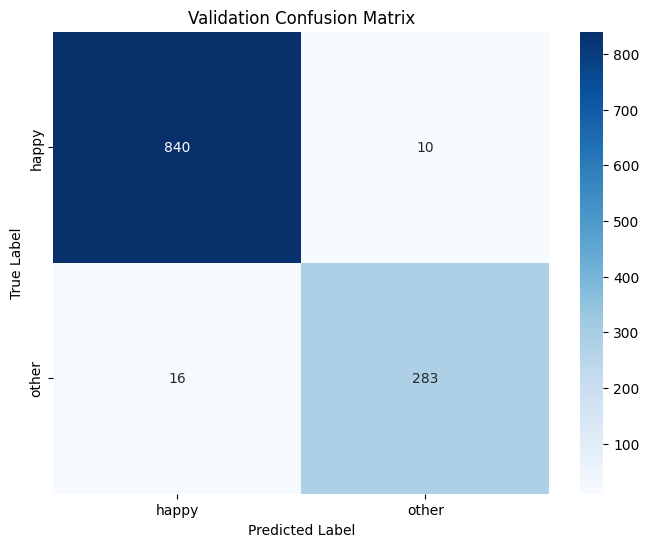

In [12]:
## Coufusion matrix 히트맵 코드

import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns 
# 이 네 가지 라이브러리가 필요합니다.

def plot_confusion_matrix(all_labels, all_preds, target_emotions, title="Confusion Matrix"):
    """
    컨퓨전 매트릭스를 계산하고 히트맵으로 시각화합니다.
    
    Args:
        all_labels (np.array): 실제 레이블 (정답)
        all_preds (np.array): 모델의 예측 레이블
        target_emotions (list): 레이블 이름 리스트 (예: ['anger', 'happy', ...])
        title (str): 그래프 제목
    """
    
    # 1. 컨퓨전 매트릭스 계산
    cm = confusion_matrix(all_labels, all_preds)
    
    # 2. 시각화 설정
    plt.figure(figsize=(8, 6))
    
    # 히트맵 생성 (fmt='d'는 정수형 포맷을 의미)
    sns.heatmap(
        cm, 
        annot=True,          # 셀 안에 값 표시
        fmt='d',             # 정수형 포맷
        cmap='Blues',        # 색상 맵 설정
        xticklabels=target_emotions, # X축 레이블 (예측)
        yticklabels=target_emotions  # Y축 레이블 (실제)
    )
    
    # 3. 레이블 및 제목 설정
    plt.title(title)
    plt.ylabel('True Label') # 실제 레이블 (정답)
    plt.xlabel('Predicted Label') # 예측 레이블
    plt.show()



TARGET_EMOTIONS = ["happy","other"] 

# 📊 최종 성능 평가 수행 부분
trained_model = model # 학습된 모델을 사용하거나 불러온 모델을 사용
print("\n📊 최종 성능 평가 중...")

trained_model.eval()
all_labels = []
all_preds = []

if len(val_loader.dataset) > 0:
    with torch.inference_mode():
        for inputs, labels in tqdm(val_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = trained_model(inputs)
            _, preds = torch.max(outputs, 1) # 예측값 (클래스 인덱스)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # ⭐️ 시각화 함수 호출!
    plot_confusion_matrix(all_labels, all_preds, TARGET_EMOTIONS, "Validation Confusion Matrix")
    
    # ... (classification_report 출력 로직) ...
else:
    print("⚠️ 경고: 유효성 검증 데이터셋에 로드된 샘플이 없어 평가를 건너뜁니다.")